In [1]:
!pip install jiwer tensorflow IPython librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import IPython.display as ipd

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive

drive.mount('/content/drive')

wavs_path = '/content/drive/My Drive/audio/audio/'
metadata_path = '/content/drive/My Drive/audio/clip1.csv'

metadata_df = pd.read_csv(metadata_path, sep=',', header=None, quoting=3)

metadata_df.head(10)

Mounted at /content/drive


,0,1
0,clip_1,asante kwa zawadi ya roho wako mtakatifu roho ...
1,clip_2,asante bwana kwasababu pamoja na maumivu tulio...
2,clip_3,hali zingine ambazo hatuzielewi wakati mwingin...
3,clip_4,za kufanya njia hata pasipo na njia tunakushuk...
4,clip_5,ine tena tunajikabidhi mikononi mwako siku nyi...
5,clip_6,gange ukatuponye na ukafanye jambo ulilokusubi...
6,clip_7,mshangilie bwana Yesu kwa makofi mengi makofi ...
7,clip_8,Amen Amen aya mkaribishe jilani yako mwambie k...
8,clip_9,Kristo alafu naomba jamani wale ambao tumekaa ...
9,clip_10,n’ghe shuleni ulikuwa back bencher kazini inaw...


In [5]:
audio1= wavs_path+'clip_10.wav'
ipd.Audio(audio1)

Output hidden; open in https://colab.research.google.com to view.

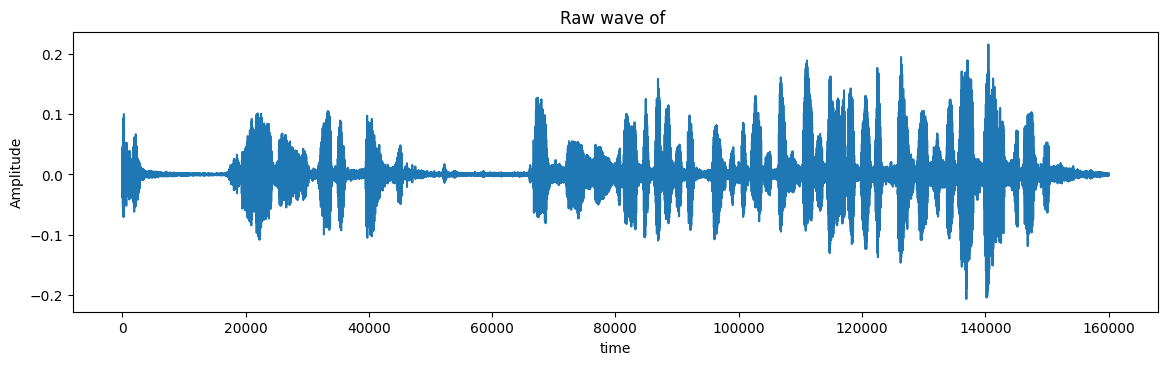

In [6]:
import librosa
samples, sample_rate = librosa.load(wavs_path+'clip_10.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

In [7]:
metadata_df.columns = ['file_name', 'transcription']
metadata_df = metadata_df[['file_name', 'transcription']]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,transcription
0,clip_162,akili yako utayafanya tutatembea mbele kidogo ...
1,clip_149,kwa sababu alikuwa ni mnadhili wa Mungu aliyet...
2,clip_158,ke walitalajiwa kuongea kinini? Ki-ga-li-la-ya...


In [8]:
split = int(len(metadata_df)* .90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f'Size of the training set: {len(df_train)}')
print(f'Size of the training set: {len(df_val)}')


Size of the training set: 198
Size of the training set: 22


In [9]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_cha = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [18]:
frame_length = 256
frame_step = 160
fft_length = 380

def encode_signal_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, sample_rate = tf.audio.decode_wav(file)
    if len(audio.shape) > 1:
        audio = tf.reduce_mean(audio, axis=-1)

    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectrogram, label


In [19]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]), list(df_train["transcription"])))

train_dataset = (
    train_dataset.map(encode_signal_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    list(df_val['file_name']), list(df_val['transcription'])
))
validation_dataset = (
    validation_dataset.map(encode_signal_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [20]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 191), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

<Figure size 800x500 with 0 Axes>

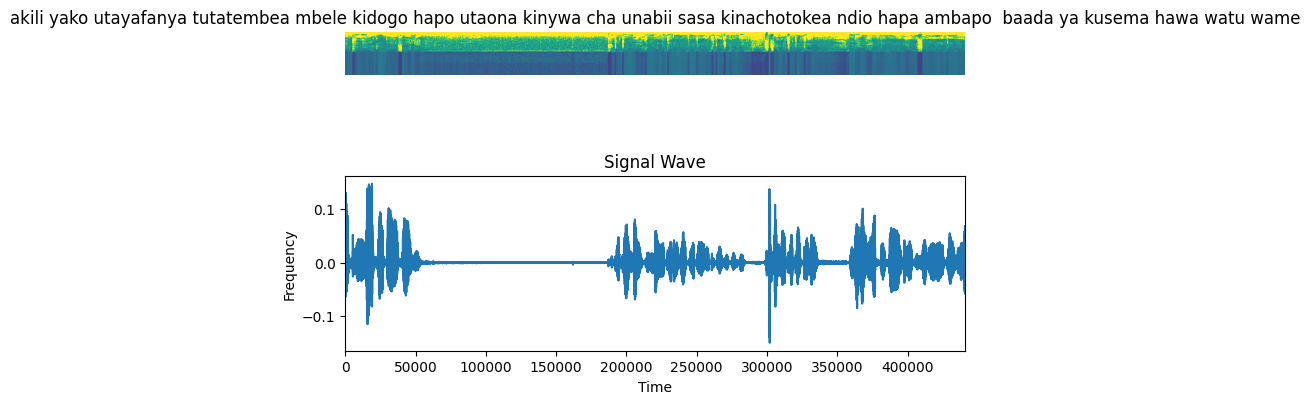

In [24]:
figer = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    fig = plt.figure(figsize=(8,5))
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_cha(label)).numpy().decode("utf-8")
    ax = plt.subplot(2,1,1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    wav_file = df_train['file_name'].iloc[0]
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)

    if len(audio.shape) > 1:
        audio = tf.reduce_mean(audio, axis=-1)  # Convert to mono if stereo

    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_aspect("auto")
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

